# Event Study in Python
This program contains the codes that can be used in testing market reaction and doing sample partition. Event_CS.csv include the following variable:
-    **permno: security identifier**
-    **conm: company name**
-    **event_date: earnings announcement date**
-    **partition_var1: whether reported earnings beat analyst forecast consensus**
-    **partition_var2: whether firms report loss**

### Part A: Clean Data

**Loading pandas and dataset**

In [1]:
import pandas as pd
import scipy.stats as st #Package for doing statistical test
import matplotlib.pyplot as plt #Package for drawing pictures
pd.options.mode.chained_assignment = None #Set off some pandas outputs

In [2]:
#Import event data
event = pd.read_csv('finaldata.csv',parse_dates = ['event_date'])
event

,permno,event_date
0,12914,2018-11-23
1,14593,2012-03-19
2,93174,2012-11-30
3,14141,2013-10-03
4,90874,2012-03-31
5,85326,2012-11-06
6,21119,2020-01-27
7,11823,2020-04-17
8,19012,2020-01-28
9,86996,2019-07-29


In [3]:
#Duplicates check
event=event.drop_duplicates()
event

,permno,event_date
0,12914,2018-11-23
1,14593,2012-03-19
2,93174,2012-11-30
3,14141,2013-10-03
4,90874,2012-03-31
5,85326,2012-11-06
6,21119,2020-01-27
7,11823,2020-04-17
8,19012,2020-01-28
9,86996,2019-07-29


In [17]:
#Import stock price data
stockprice = pd.read_csv('Crsp_2010_2020.csv',parse_dates = ['date','calendar_day'])


,permno,date,calendar_day,trading_day,abnormal_ret
0,10001,2010-01-04,2010-01-04,1,-0.021982
1,10001,2010-01-05,2010-01-05,2,-0.009228
2,10001,2010-01-06,2010-01-06,3,0.009730
3,10001,2010-01-07,2010-01-07,4,-0.036808
4,10001,2010-01-08,2010-01-08,5,0.033979
...,...,...,...,...,...
19725397,93436,2017-01-26,2017-01-26,1779,-0.006550
19725398,93436,2017-01-27,2017-01-27,1780,0.003348
19725399,93436,2017-01-30,2017-01-30,1781,-0.002107
19725400,93436,2017-01-31,2017-01-31,1782,0.004348


- permno: security identifier
- date: trading calendar day
- calendar_day: trading calendar day
- trading_day: trading day index
- abnormal_ret: raw return adjusted for delisting return and market return

**Preprocess dataset before merging**

In [5]:
#Filter Event Firms' Stock Price
relatedsp=pd.merge(event, stockprice, how = 'left', on = 'permno')[['permno', 'date', 'abnormal_ret','calendar_day','trading_day']]

In [6]:
#Duplicate Repetitive Merge
relatedsp=relatedsp.drop_duplicates()

In [7]:
#Reset Index for Loop
event=event.reset_index(drop=True)
relatedsp=relatedsp.reset_index(drop=True)

**Merge each event to the closest trading day**

In [8]:
#This code is to loop over each event and match each event with the cloest trading day within [0,+7].
event_trade_date = pd.DataFrame()
for r in range(0,len(event)):
    #Select event related price
    relatedsp_temp=relatedsp[relatedsp['permno']==event.loc[r,"permno"]] 
    #Assign event date to a seperate variable
    relatedsp_temp['event_date']=event.loc[r,'event_date'] 
    #Use the calendar_day minus event day
    relatedsp_temp['relative_day']=(relatedsp_temp['calendar_day']-relatedsp_temp['event_date']).dt.days 
    #Select match within [0,+7]
    relatedsp_temp=relatedsp_temp[(relatedsp_temp['relative_day']>=0)&(relatedsp_temp['relative_day']<=7)]
    #Sort and filter the trading day with minimum day difference
    relatedsp_temp=relatedsp_temp.sort_values(by = 'relative_day', ascending = True)
    temp=relatedsp_temp.head(1)[['permno', 'event_date', 'trading_day']]
    event_trade_date = event_trade_date.append(temp.head(1), ignore_index = True)
    
print("Number of Matched with CRSP:",len(event_trade_date))
event_trade_date.rename(columns={'trading_day':'event_trading_day'}, inplace=True)
print(event_trade_date)

Number of Matched with CRSP: 36
    permno event_date  event_trading_day
0    12914 2018-11-23             2240.0
1    14593 2012-03-19              557.0
2    93174 2012-11-30              734.0
3    14141 2013-10-03              945.0
4    90874 2012-03-31              567.0
5    19012 2020-01-28             2534.0
6    86996 2019-07-29             2408.0
7    17178 2020-02-05             2540.0
8    17281 2019-10-29             2473.0
9    17332 2019-08-12             2418.0
10   13908 2019-10-31             2475.0
11   15906 2019-11-06             2479.0
12   16756 2019-12-12             2504.0
13   90090 2018-07-18             2150.0
14   18592 2019-06-26             2386.0
15   16338 2016-11-15             1731.0
16   64899 2015-04-09             1325.0
17   93096 2015-03-13             1307.0
18   77610 2017-02-21             1796.0
19   89617 2014-10-16             1206.0
20   15735 2016-05-19             1606.0
21   19403 2020-08-24             2679.0
22   15623 2015-11-05    

**Collect event window [-5,10] trading data**

In [9]:
#This code is to assign the 16 trading days around the event date, and transform each trading day to an event day.

#Merge the event with event_trading_day to price dataset 
event_price=pd.merge(event_trade_date, relatedsp, how = 'left', on = ['permno'])
#Calculate the trading day difference
event_price['event_day']=event_price['trading_day']-event_price['event_trading_day']
#Filter by graph window [-5,+10]
event_price=event_price[(event_price['event_day']<=10) & (event_price['event_day']>=-5)]
#Sort variable
event_price=event_price.sort_values(by = ['permno','event_date','event_day'], ascending = True)
event_price=event_price[['permno', 'event_date', 'calendar_day','trading_day','event_day','abnormal_ret']]
event_price.head(16)

,permno,event_date,calendar_day,trading_day,event_day,abnormal_ret
1840,12914,2018-11-23,2018-11-15,2235.0,-5.0,-0.022536
1841,12914,2018-11-23,2018-11-16,2236.0,-4.0,0.021976
1842,12914,2018-11-23,2018-11-19,2237.0,-3.0,-0.010194
1843,12914,2018-11-23,2018-11-20,2238.0,-2.0,0.019773
1844,12914,2018-11-23,2018-11-21,2239.0,-1.0,-0.002579
1845,12914,2018-11-23,2018-11-23,2240.0,0.0,0.001199
1846,12914,2018-11-23,2018-11-26,2241.0,1.0,-0.006991
1847,12914,2018-11-23,2018-11-27,2242.0,2.0,0.000466
1848,12914,2018-11-23,2018-11-28,2243.0,3.0,-0.002612
1849,12914,2018-11-23,2018-11-29,2244.0,4.0,0.008745


**Delete events without sufficient trading data**

In [10]:
event_price = event_price[event_price.groupby(['permno','event_date']).event_day.transform(len) ==16]

**Combine original data**

In [11]:
temp1=pd.merge(event, event_price, how = 'left', on = ['permno','event_date'])

**Generate cumulative return**

In [12]:
#For graphing, we need a longer window of [-5,10]

#Keep price data within window
graph_sample=temp1[(temp1['event_day']<=10) & (temp1['event_day']>=-5)] 
graph_sample
#Cumulatively sum the return
graph_sample['car'] = graph_sample.groupby(['permno','event_date'])['abnormal_ret'].apply(lambda x: x.cumsum()) 
graph_sample.shape

(560, 7)

In [13]:
#For testing, we need a shorter window of [-1,1]

#Keep price data within window
test_sample=temp1[(temp1['event_day']<=1) & (temp1['event_day']>=-1)]
#Cumulatively sum the return
test_sample['car'] = test_sample.groupby(['permno','event_date'])['abnormal_ret'].apply(lambda x: x.cumsum()) 
#Keep only one CAR observation for each event
test_sample=test_sample[test_sample['event_day']==1]
test_sample.shape

(35, 7)

### Part B: Event Study Graph and Statistic Test

**Draw event study graph**

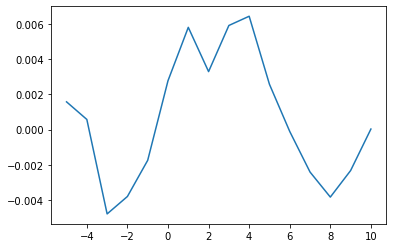

In [14]:
mean_ar=graph_sample.groupby('event_day')['car'].mean()
plt.plot(mean_ar)

**Statistical test**

In [15]:
#Print average car
print(test_sample['car'].mean())
#Do the test and print t and p values
t, p = st.ttest_1samp(test_sample['car'], 0)
print("ttest_1samp_stats: t = %.3f  p = %.3f" % (t, p))

0.009577680131428574
ttest_1samp_stats: t = 1.606  p = 0.117


### Part C: Sample Partition

**Partition graph**

In [16]:
#Split the sample based on partition variable
group1=graph_sample[graph_sample['partition_var1']==0]
group2=graph_sample[graph_sample['partition_var1']==1]

KeyError: 'partition_var1'

In [ ]:
#Draw picture for group 1
mean_ar=group1.groupby('event_day')['car'].mean()
plt.plot(mean_ar)

In [ ]:
#Draw picture for group 2
mean_ar=group2.groupby('event_day')['car'].mean()
plt.plot(mean_ar)

**Test market reaction for each group**

In [ ]:
#Split the sample based on partition variable
group1=test_sample[test_sample['partition_var1']==0]
group2=test_sample[test_sample['partition_var1']==1]

In [ ]:
#Average Car for group 1
print("Average Market Reaction: car = %.3f" % group1['car'].mean())

In [ ]:
#Average Car for group 2
print("Average Market Reaction: car = %.3f" % group2['car'].mean())

In [ ]:
#Test the difference across group

#Two sample test
t,p=st.ttest_ind(group1['car'], group2['car'])
print("Comparing Two Groups' Car: t = %.3f  p = %.3f" % (t, p))
